In [25]:
import pandas as pd 
import numpy as np
import pytrends.request as ptrq

import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import performance_metrics

import plotly.express as px
import plotly.graph_objects as go

import dash_bootstrap_components as dbc
from dash_bootstrap_templates import ThemeChangerAIO, template_from_url
from dash_bootstrap_templates import load_figure_template

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import itertools
load_figure_template('solar')

In [2]:
mdf = pd.read_csv("iqvia_data/New Analysis (1).csv")
mdf['Date'] = mdf['Date'].str.replace('_1', '')
mdf = mdf.rename(columns = {' Vol': 'Vol'})
mdf['date'] = pd.to_datetime(mdf["Date"], format='%Y%m%d')

WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\AppData\Local\Temp\ipykernel_17292\2679158348.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mdf = pd.read_csv("iqvia_data/New Analysis (1).csv")



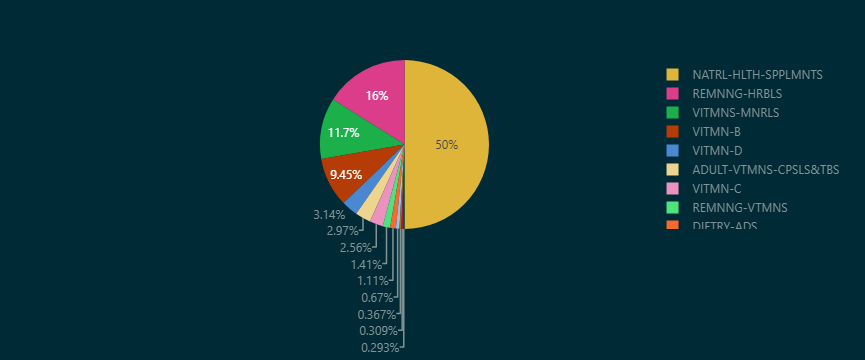

In [6]:
#to streamlit
fig = px.pie(mdf,
            values = mdf['Product Class'].value_counts().values,
            names = mdf['Product Class'].value_counts().index)
fig.update_layout(template='solar', paper_bgcolor='#002b36')

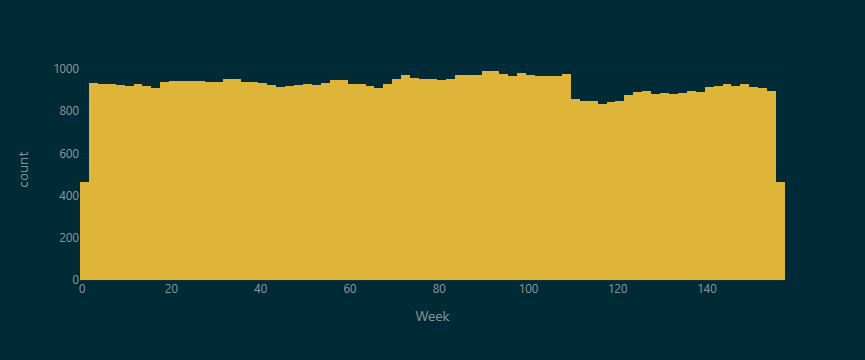

In [7]:
fig = px.histogram(mdf, x = 'Week')
fig.update_layout(template='solar', paper_bgcolor='#002b36')
#fig.update_traces(marker=dict(color='#00afaf'), line=dict(color='#eee8d5'))

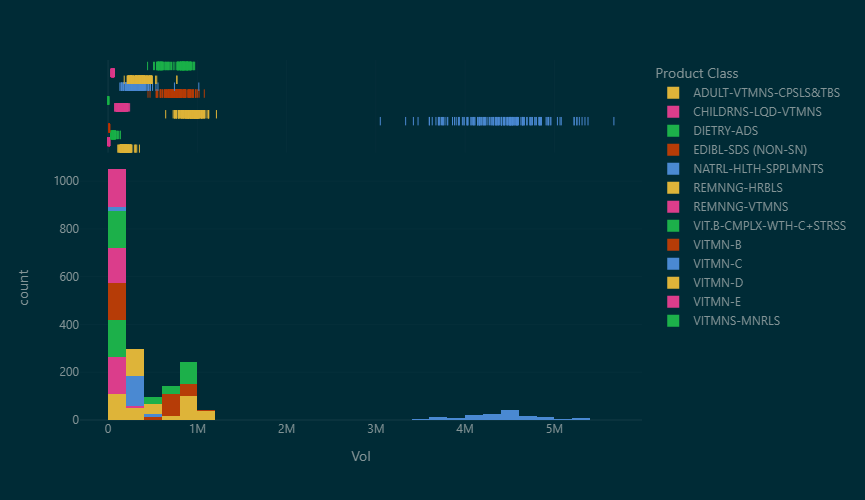

In [8]:
fig = px.histogram(mdf.groupby(by=['Product Class', 'date']).sum().reset_index(),
                   x = 'Vol',
                   color = 'Product Class',
                   marginal = 'rug',
                   width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')
#fig.update_traces(marker=dict(color='#00afaf'), line=dict(color='#eee8d5'))

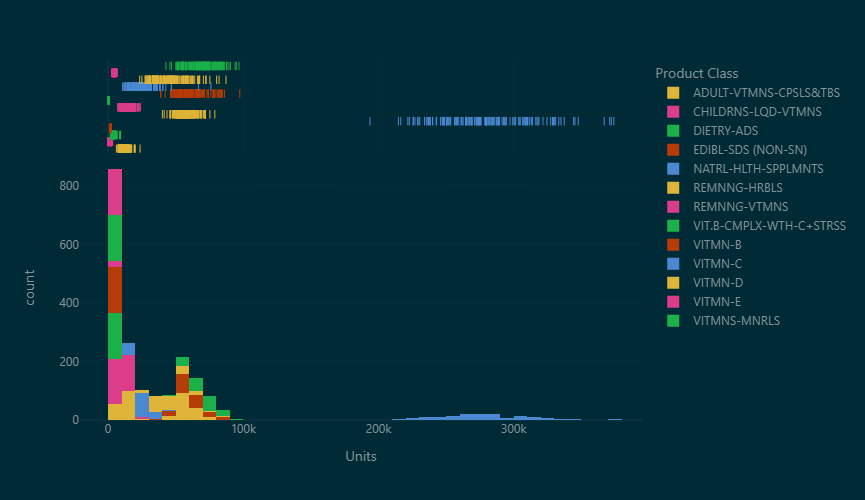

In [9]:
fig = px.histogram(mdf.groupby(by=['Product Class', 'date']).sum().reset_index(),
                   x = 'Units',
                   color = 'Product Class',
                   marginal = 'rug',
                   width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')
#fig.update_traces(marker=dict(color='#00afaf'), line=dict(color='#eee8d5'))

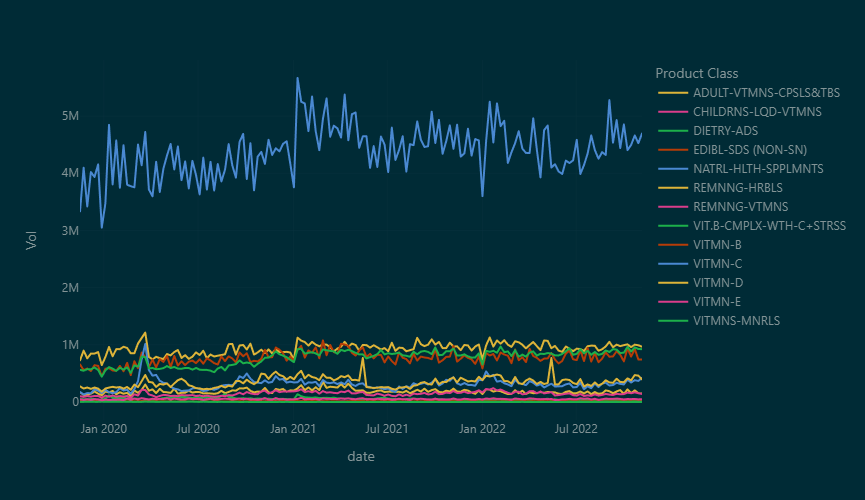

In [10]:
#to streamlit
fig = px.line(mdf.groupby(by=['Product Class', 'date']).sum().reset_index(),
             x = 'date',
             y = 'Vol',
             color = 'Product Class',
             width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')

In [14]:
product_class = 'NATRL-HLTH-SPPLMNTS'
product_class = 'VITMN-B'
gr_part_data = mdf.loc[mdf['Product Class'] == product_class]

gr_part_data = gr_part_data.groupby(by='date').agg({'Vol': 'sum',
                                         'Units': 'sum',
                                         'UPC': 'count'}).reset_index()

gr_part_data['Vol_per_UPC'] = gr_part_data['Vol'] / gr_part_data['UPC']
gr_part_data['Vol_per_Unit'] = gr_part_data['Vol'] / gr_part_data['Units']
gr_part_data['Units_per_UPC'] = gr_part_data['Units'] / gr_part_data['UPC']

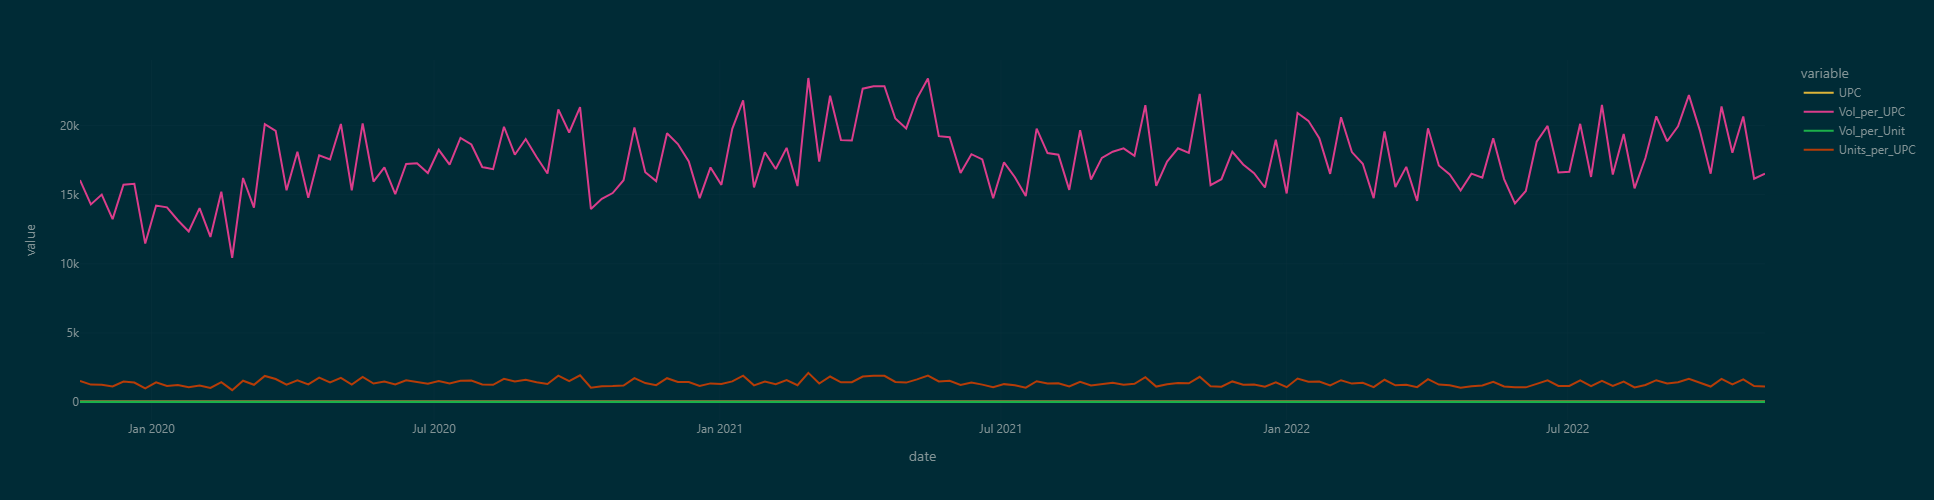

In [15]:
fig = px.line(gr_part_data,
             x = 'date',
             y = gr_part_data.columns[3:7],
             #color = 'Product Class',
             width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')

# Data Preparation

In [13]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [16]:
predict_type = 'Units'

part_df = gr_part_data.rename(columns = {'date':'ds', predict_type: 'y'})[['ds', 'y']]
part_df = part_df.loc[part_df['ds'] > '2020-05-10']
#part_df = part_df.loc[~((part_df['ds'].dt.month == 1) & (part_df['ds'].dt.day.isin([1,2])))]

part_df_ = part_df.copy()
part_df_.index = part_df['ds']
part_df_ = part_df_.drop(columns = 'ds')
part_df = part_df.resample('2W', on='ds').sum().reset_index()

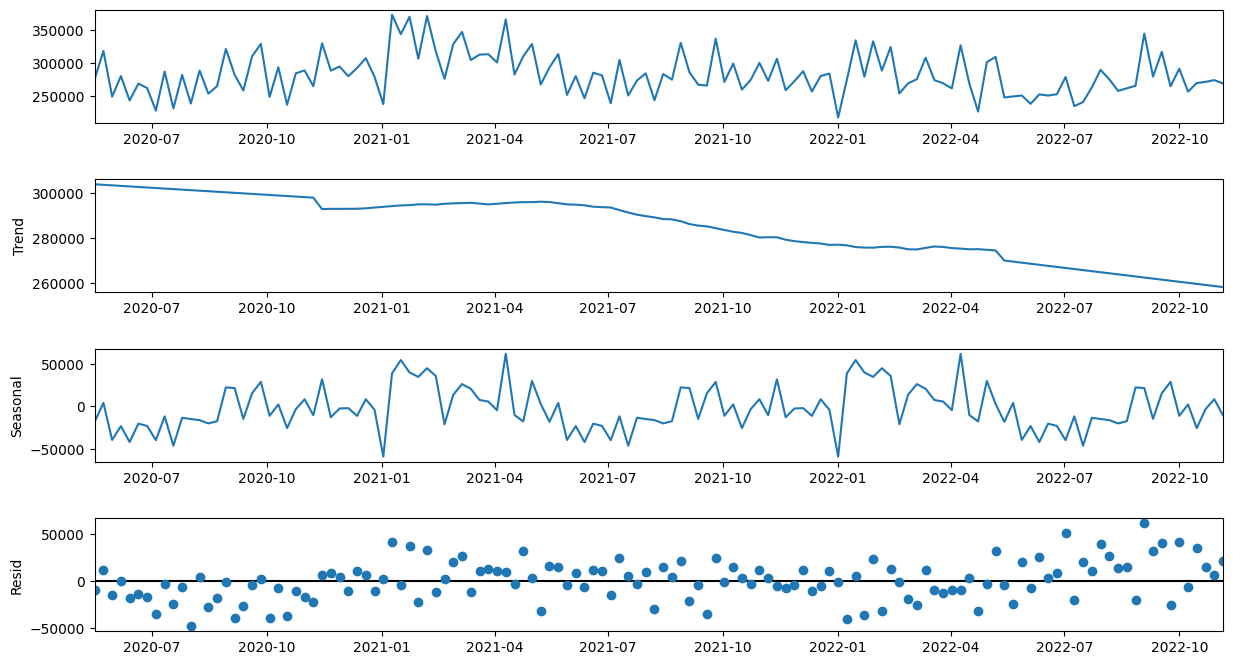

In [36]:
decomposition = sm.tsa.seasonal_decompose(part_df_, model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

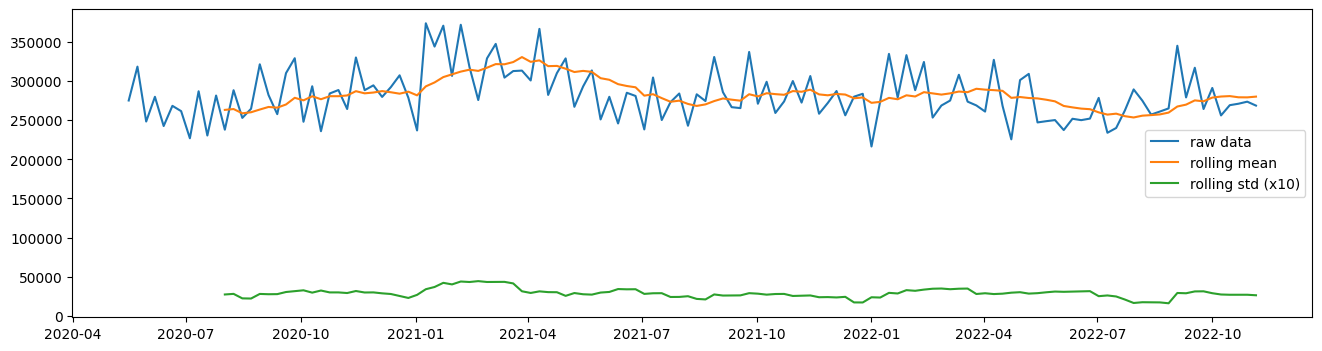

In [37]:
test_stationarity(part_df_.y,'raw data')

In [38]:
ADF_test(part_df_.y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.098
P-value = 0.027
Critical values :
	1%: -3.4833462346078936 - The data is not stationary with 99% confidence
	5%: -2.8847655969877666 - The data is  stationary with 95% confidence
	10%: -2.5791564575459813 - The data is  stationary with 90% confidence


In [39]:
y = part_df_.y

### Detrend

 > Is the de-trended data stationary ?
Test statistic = -4.489
P-value = 0.000
Critical values :
	1%: -3.477261624048995 - The data is  stationary with 99% confidence
	5%: -2.8821181874544233 - The data is  stationary with 95% confidence
	10%: -2.5777431104939494 - The data is  stationary with 90% confidence


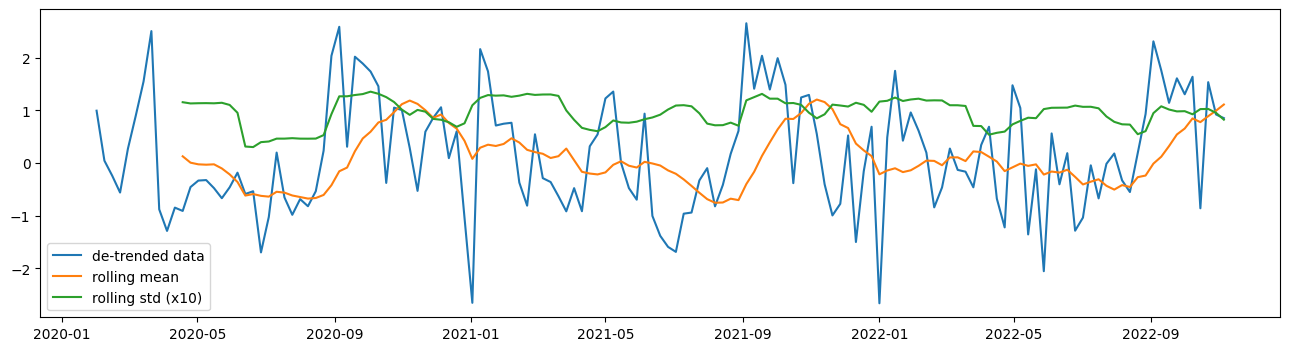

In [36]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

### Differencing

 > Is the 12 lag differenced data stationary ?
Test statistic = -9.576
P-value = 0.000
Critical values :
	1%: -3.4750180242954167 - The data is  stationary with 99% confidence
	5%: -2.8811408028842043 - The data is  stationary with 95% confidence
	10%: -2.577221358046935 - The data is  stationary with 90% confidence


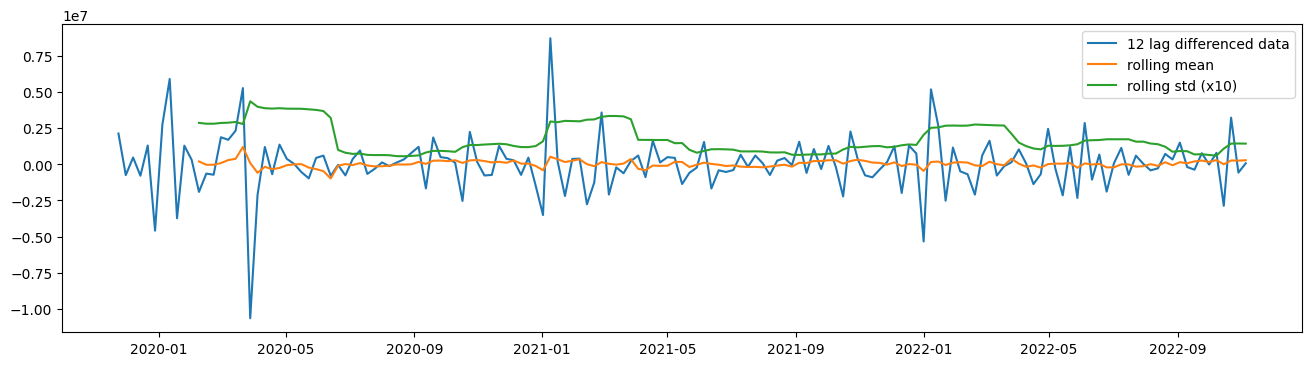

In [37]:
y_12lag =  y - y.shift(1)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.349
P-value = 0.013
Critical values :
	1%: -3.486055829282407 - The data is not stationary with 99% confidence
	5%: -2.8859430324074076 - The data is  stationary with 95% confidence
	10%: -2.5797850694444446 - The data is  stationary with 90% confidence


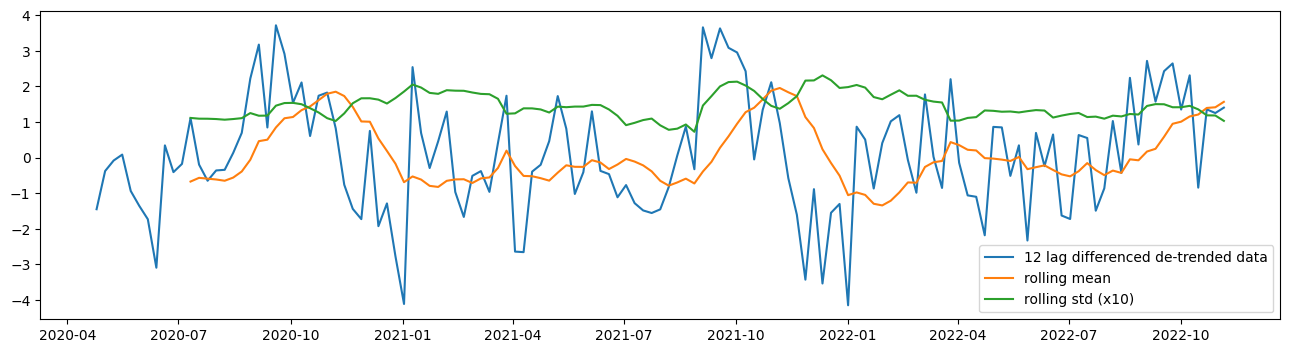

In [38]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# SARIMAX

In [12]:
y_train = y[y.index <= '2022-09-15']
y_test = y[y.index > '2022-09-15']

NameError: name 'y' is not defined

In [59]:
SARIMAXmodel = SARIMAX(y_train, order = (1, 1, 1), seasonal_order=(1, 1, 2, 52))
SARIMAXmodel = SARIMAXmodel.fit()

WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.


WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency W-SAT will be used.


WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.




In [60]:
y_pred = SARIMAXmodel.get_forecast(len(y_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = y_test.index
y_pred_out = y_pred_df["Predictions"] 

In [61]:
y_pred_df['y_hat'] = y

<AxesSubplot:xlabel='ds'>

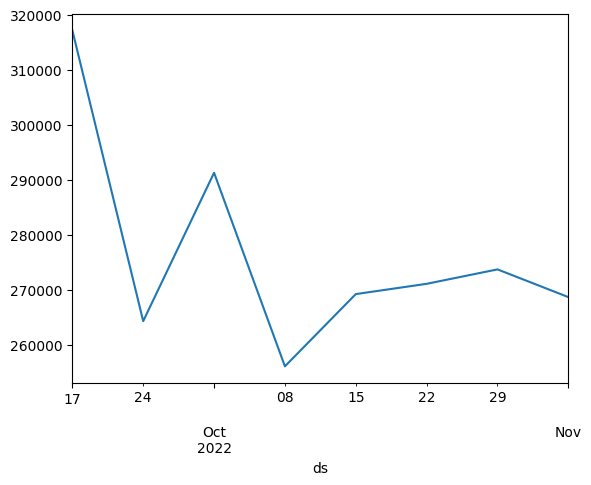

In [62]:
y_pred_df['y_hat'].plot()

In [63]:
mean_absolute_percentage_error(y_pred_df['Predictions'].values, y_pred_df['y_hat'].values)

0.10730538959820007

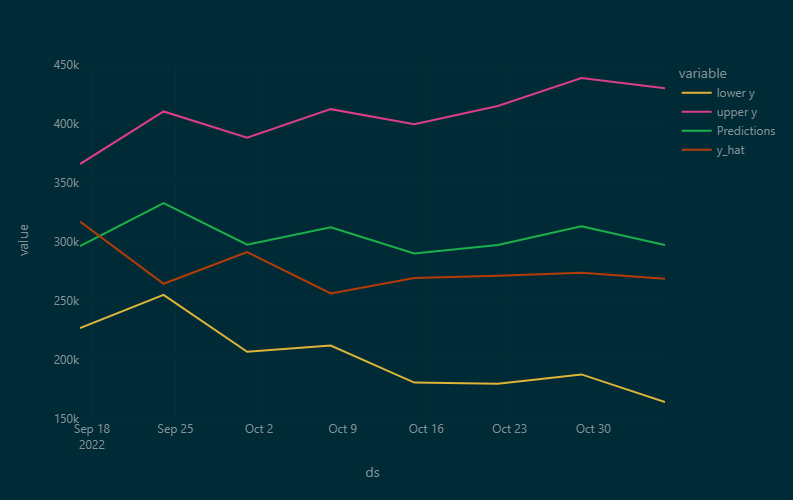

In [64]:
fig = px.line(y_pred_df,
             x = y_pred_df.index,
             y = y_pred_df.columns[0:4],
             #color = 'Product Class',
             width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')

# Prophet

In [17]:
split_int = 58
df_train = part_df[1:split_int]
df_val = part_df[split_int:-1]

In [74]:
model = NeuralProphet(n_changepoints=10, seasonality_mode = 'multiplicative',
                      yearly_seasonality = True,
                      weekly_seasonality = False,
                      daily_seasonality = False,)
#df_train, df_val = model.split_df(part_df, freq='W', valid_p = 1/12)
model.add_country_holidays('CA')
metrics = model.fit(df_train, validation_df=df_val, freq="2W")

INFO - (NP.df_utils._infer_frequency) - Major frequency 2W-SUN corresponds to 98.246% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 2W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 788
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (4) is too small than the required number for the learning rate finder (204). The results might not be optimal.
Loading `train_dataloader` to estimate number of stepping batches.
WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\anaconda3\envs\nf_geo\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py

Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=204` reached.
Restoring states from the checkpoint path at C:\Users\serhiy\Documents\natural_factors\.lr_find_b7a6d8a2-dc37-4b24-a905-b5f1857b3d6d.ckpt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name          | Type             | Params
---------------------------------------------------
0 | metrics_train | MetricCollection | 0     
1 | metrics_val   | MetricCollection | 0     
2 | season_params | ParameterDict    | 12    
3 | event_params  | ParameterDict    | 14    
---------------------------------------------------
39        Trainable params
0         Non-trainable params
39        Total params
0.000     Total estimated model params size (MB)


ConfigValueError: Union types are not supported:
loss_func: Union[str, _Loss, Callable]
    full_key: 
    object_type=None

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.359% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 98.81% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\serhiy\anaconda3\envs\nf_geo\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the numb

Predicting: 10it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


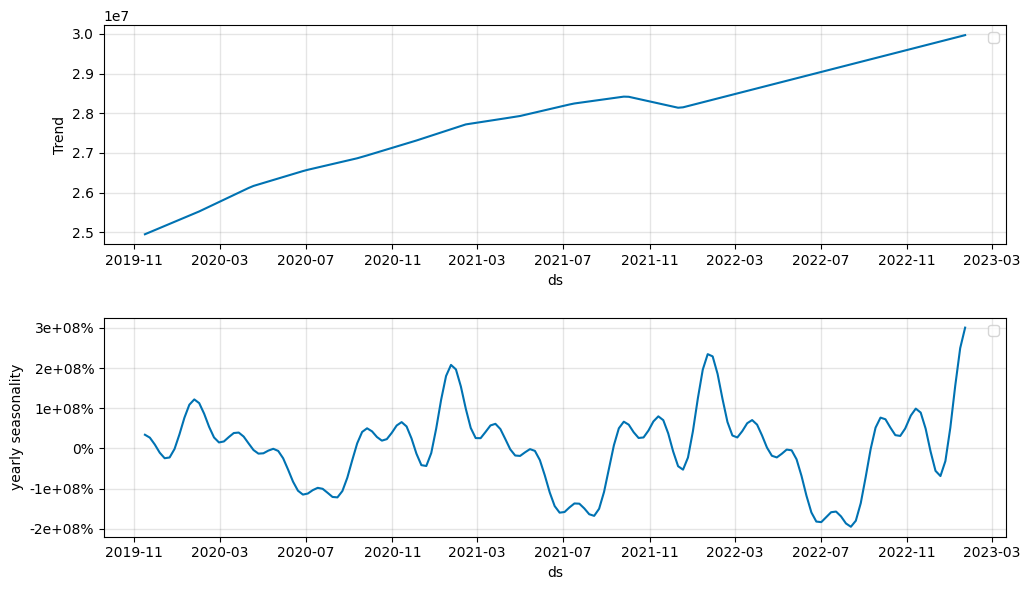

In [162]:
future = model.make_future_dataframe(part_df, periods=12, n_historic_predictions=True)
forecast = model.predict(future)
model.plot_components(forecast)
plt.show()

In [163]:
metrics.min()

MAE_val        6.895513e+05
RMSE_val       1.002241e+06
Loss_val       8.334050e-03
RegLoss_val    0.000000e+00
epoch          0.000000e+00
MAE            9.842305e+05
RMSE           1.376683e+06
Loss           1.234190e-02
RegLoss        0.000000e+00
dtype: float64

In [ ]:
689 551.3

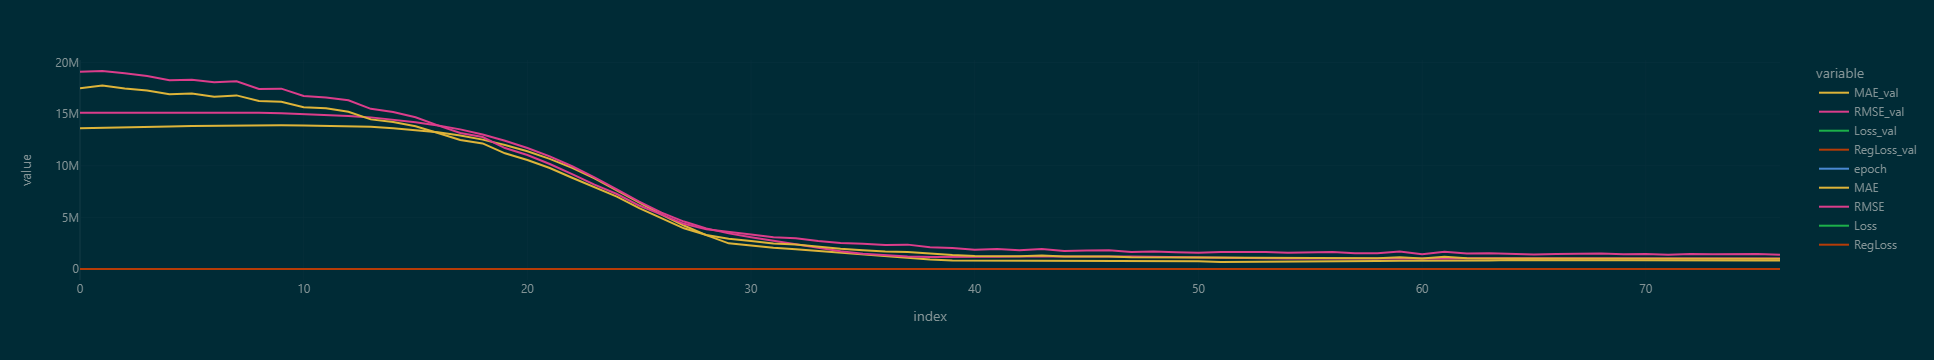

In [164]:
fig = px.line(metrics)
fig.update_layout(template='solar', paper_bgcolor='#002b36')
fig

In [165]:
forecast['y'] = forecast['y'].fillna(forecast['y'].mean())

In [ ]:
fig = go.Figure([
    go.Scatter(
        x=x,
        y=y,
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    )
])
fig.show()

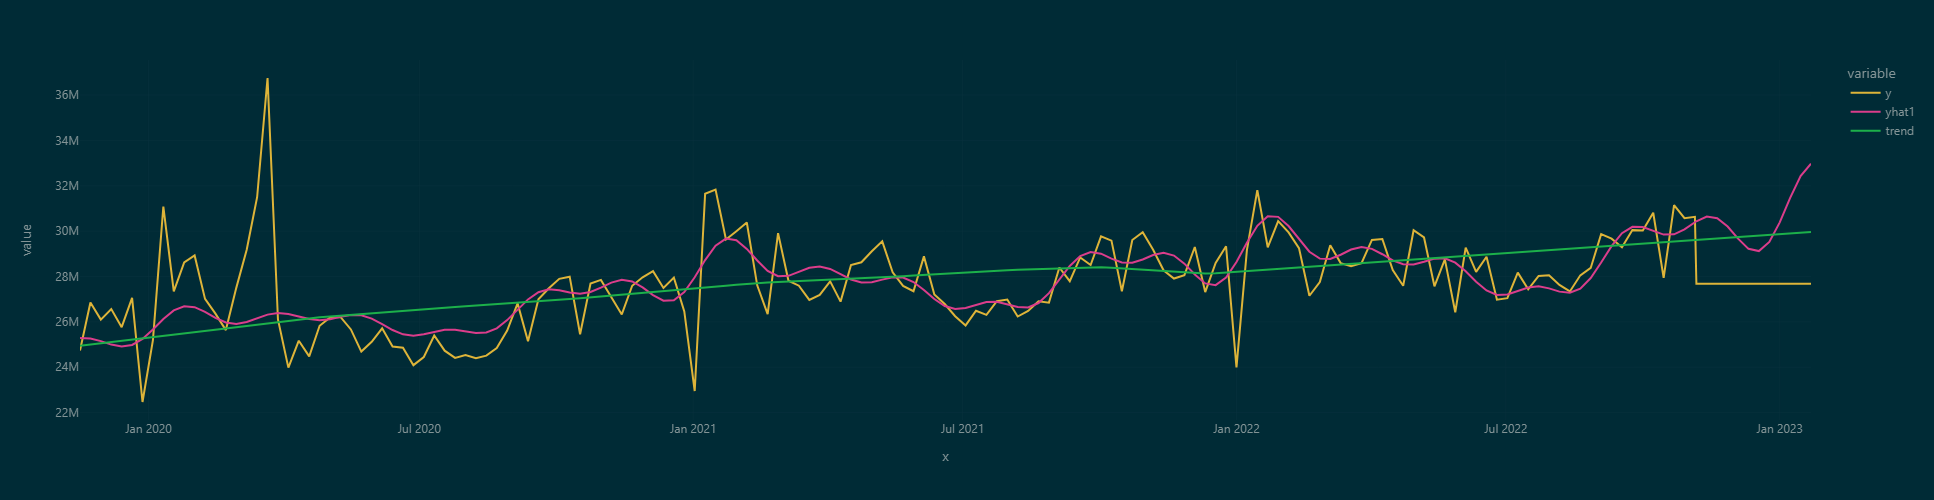

In [166]:
fig = px.line(forecast,
             x = forecast['ds'].values,
             y = forecast.columns[1:4],
             #color = 'Product Class',
             width=800, height=500)
fig.update_layout(template='solar', paper_bgcolor='#002b36')

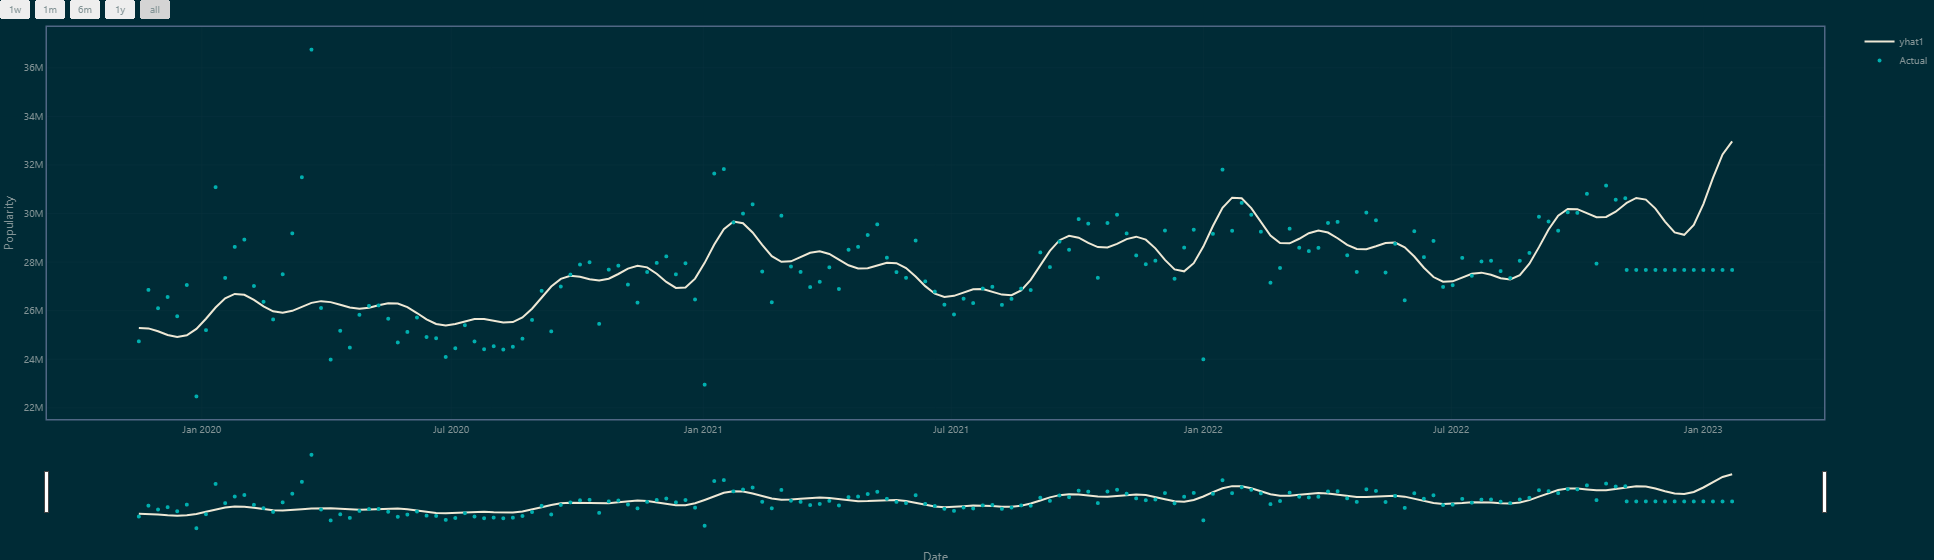

In [167]:
fig = model.plot(forecast, ylabel='Popularity', xlabel='Date', figsize=(16,8), 
               plotting_backend= 'plotly')

fig.update_layout(template='solar', paper_bgcolor='#002b36')
fig.update_traces(marker=dict(color='#00afaf'), line=dict(color='#eee8d5'))

# Classical Prophet

In [18]:
part_df

ds       y
0  2020-05-17   72929
1  2020-05-31  116496
2  2020-06-14  119902
3  2020-06-28  115076
4  2020-07-12  115411
..        ...     ...
61 2022-09-18  125057
62 2022-10-02  107673
63 2022-10-16  130832
64 2022-10-30  127353
65 2022-11-13   50840

[66 rows x 2 columns]

In [19]:
prophet_basic = Prophet(yearly_seasonality = True,
                        seasonality_prior_scale = 1,
                        changepoint_prior_scale = 0.4,
                        holidays_prior_scale = 0.15,
                       seasonality_mode = 'multiplicative')
prophet_basic.add_country_holidays('CA')
prophet_basic.fit(part_df[1:-1])

future= prophet_basic.make_future_dataframe(periods=12, freq = '2W')
forecast=prophet_basic.predict(future)

13:32:01 - cmdstanpy - INFO - Chain [1] start processing
13:32:02 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
mean_absolute_percentage_error(part_df.y, forecast.yhat[:len(part_df.y)])

0.11364463393010595

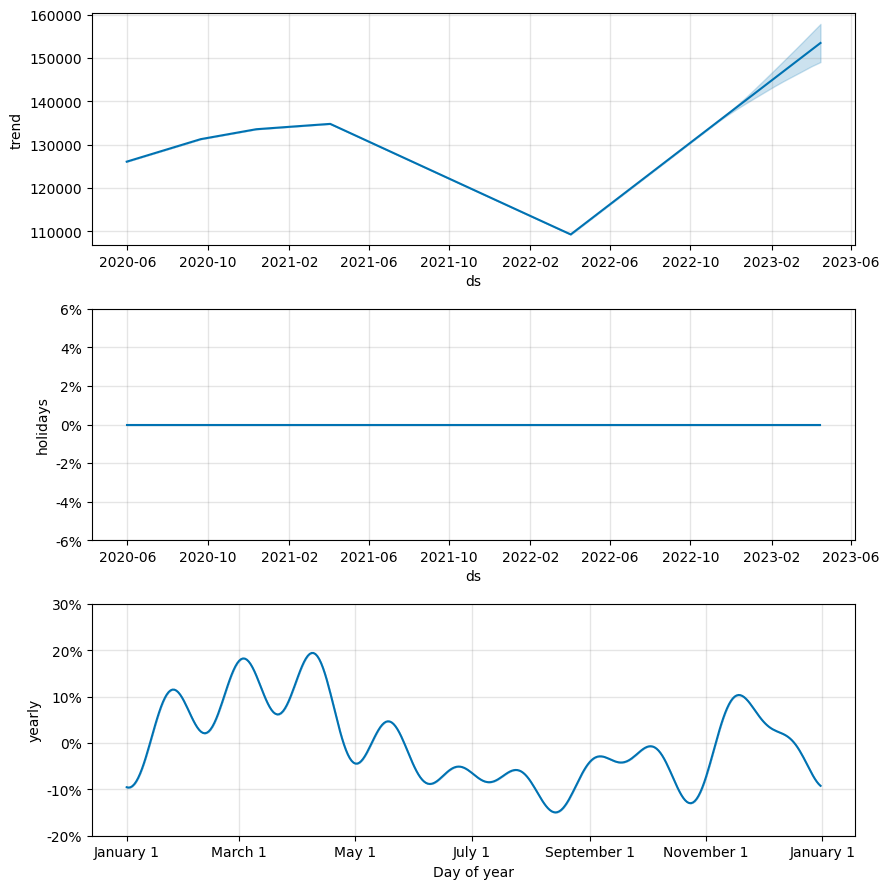

In [21]:
prophet_basic.plot_components(forecast)
plt.show()

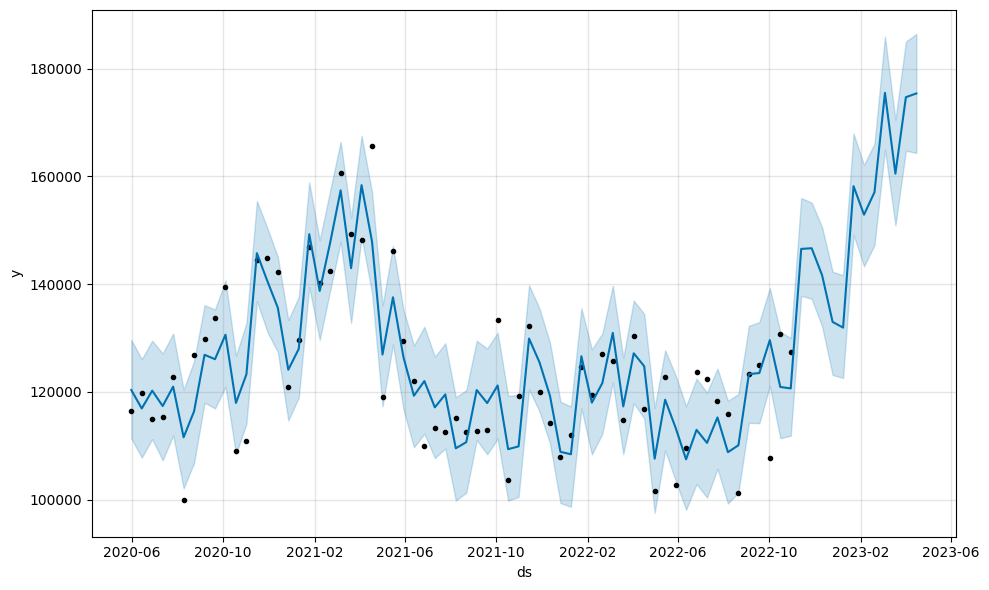

In [22]:
fig1 =prophet_basic.plot(forecast)

In [23]:
X_tst_forecast = prophet_basic.predict(df_val)

In [33]:
_fcst = forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'yhat']].merge(part_df[1:-1], on = 'ds', how = 'outer')

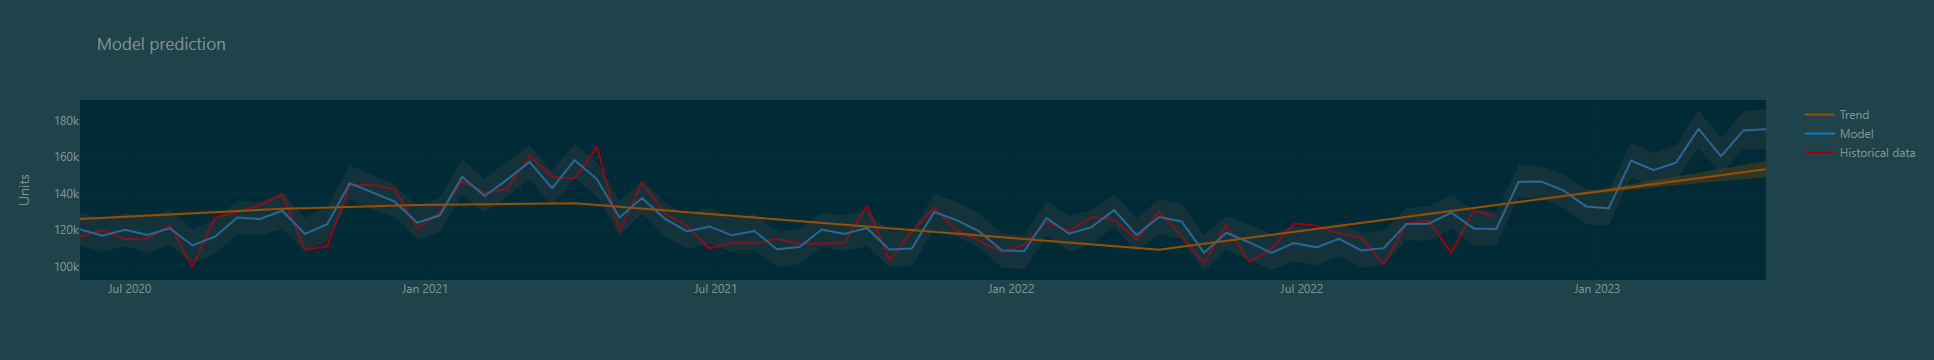

In [44]:
fig = go.Figure([
    go.Scatter(
        name='Historical data',
        x=_fcst['ds'],
        y=_fcst['y'],
        mode='lines',
        line=dict(color='rgb(153, 0, 15)'),
    ),
    go.Scatter(
        name='Model',
        x=_fcst['ds'],
        y=_fcst['yhat'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Model upper error',
        x=_fcst['ds'],
        y=_fcst['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Model lower error',
        x=_fcst['ds'],
        y=_fcst['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='Trend',
        x=_fcst['ds'],
        y=_fcst['trend'],
        mode='lines',
        line=dict(color='rgb(153, 79, 0)'),
    ),
    go.Scatter(
        name='Trend upper error',
        x=_fcst['ds'],
        y=_fcst['trend_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Trend lower error',
        x=_fcst['ds'],
        y=_fcst['trend_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(153, 79, 0, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title=predict_type,
    title='Model prediction',
    hovermode="x"
)
fig.show()

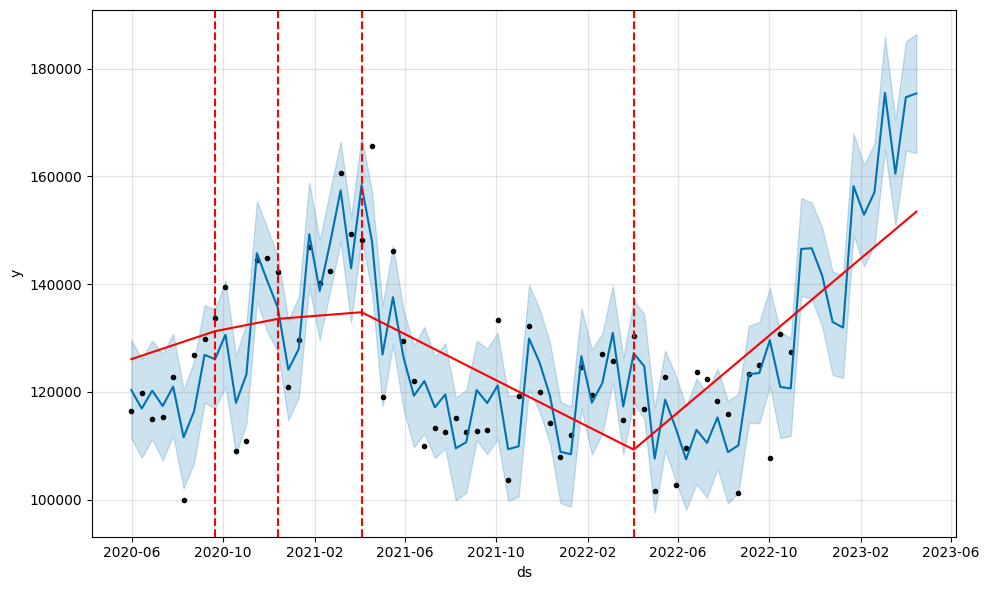

In [39]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.savefig('fcst_iqvia.png', dpi = 150)